# Background Rule

In this study, we investigate how the background rule should be treated in `ruleboost`, in particular as it relates to refitting and regularisation. In a previous implementation of corrective boosting, the background rule was not refit, which seems clearly sub-optimal as the following example shows.

(100, 1)
(100,)


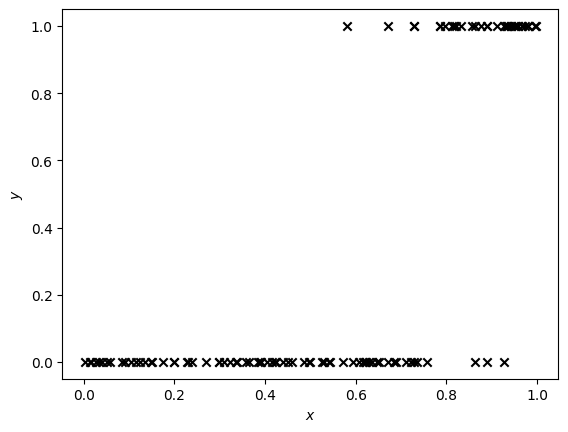

In [76]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(seed=0)
x = RNG.uniform(size=100).reshape(-1, 1)
y = RNG.binomial(1, expit(20*(x-0.75))).reshape(-1)
# y = y - y.mean()

print(x.shape)
print(y.shape)

plt.scatter(x, y, marker='x', color='black')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.show()

## Implementation of Background Rule as Empty Conjunction

In [77]:
from optikon import equal_width_propositionalization

props = equal_width_propositionalization(x)
props[:0].str_from_conj(np.array([], dtype=int))
props[:0].support_all(x)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [82]:
from optikon import max_weighted_support, equal_width_propositionalization

class RuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam

    def fit(self, x, y):
        n = len(x)
        props = equal_width_propositionalization(x)
        
        q_matrix = np.zeros(shape=(n, self.num_rules+self.fit_intercept))

        if self.fit_intercept:
            self.q_ = [props[:0]]
            q_matrix[:, 0] = 1
            self.coef_ = np.array([y.mean()])
        else:
            self.q_ = []
            q_matrix = np.zeros(shape=(n, self.num_rules))
            self.coef_ = np.zeros(shape=0)

        for i in range(self.fit_intercept, self.num_rules+self.fit_intercept):
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = y - y_hat

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            gramian = q_matrix[:, :i+1].T.dot(q_matrix[:, :i+1])
            if self.lam > 0:
                if self.fit_intercept:
                    gramian[np.diag_indices_from(gramian)[0][1:], np.diag_indices_from(gramian)[1][1:]] += self.lam
                    print(gramian)
                else:
                    gramian[np.diag_indices_from(gramian)] += self.lam

            self.coef_ = np.linalg.solve(gramian, q_matrix[:, :i+1].T.dot(y))

        return self
    
    def predict(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix.dot(self.coef_)
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'RuleBoostingRegressor({self.num_rules}, {self.max_depth})'
    
regressor_with_background_rule = RuleBoostingRegressor(num_rules=1, fit_intercept=True, lam=0).fit(x, y)
print(regressor_with_background_rule)

+0.732 if  
-0.715 if x1 <= 0.670 


In [55]:
regressor_without_background_rule = RuleBoostingRegressor(num_rules=1, fit_intercept=False).fit(x, y)
print(regressor_without_background_rule)

-0.293 if x1 <= 0.670 


In [56]:
from sklearn.metrics import mean_squared_error

x_test = RNG.uniform(size=100).reshape(-1, 1)
y_test = RNG.binomial(1, expit(20*(x-0.75))).reshape(-1)
y_test = y_test - y.mean() # use mean of training data to obtain identical train and test distribution

print('train error:', mean_squared_error(y, regressor_without_background_rule.predict(x)))
print('test error:', mean_squared_error(y_test, regressor_without_background_rule.predict(x_test)))

print('train error with intercept:', mean_squared_error(y, regressor_with_background_rule.predict(x)))
print('test error with intercept:', mean_squared_error(y_test, regressor_with_background_rule.predict(x_test)))

train error: 0.16323150847457624
test error: 0.48991632031025567
train error with intercept: 0.09031831335262504
test error with intercept: 0.4740158973477331


## Error Comparison of Models with and without Background Rule

In [58]:
for k in range(1, 4):
    regressor_with_background_rule = RuleBoostingRegressor(num_rules=k, fit_intercept=True).fit(x, y)
    print(regressor_with_background_rule)
    print('train error:', mean_squared_error(y, regressor_with_background_rule.predict(x)))
    print('test error:', mean_squared_error(y_test, regressor_with_background_rule.predict(x_test)))
    print()

+0.422 if  
-0.715 if x1 <= 0.670 
train error: 0.09031831335262504
test error: 0.4740158973477331

+0.290 if  
-0.583 if x1 <= 0.670 
+0.338 if x1 >= 0.892 
train error: 0.07920550847457626
test error: 0.47917782031025546

+0.290 if  
-0.550 if x1 <= 0.670 
+0.338 if x1 >= 0.892 
-0.050 if x1 <= 0.448 
train error: 0.07887499999999999
test error: 0.47648249999999975



In [60]:
for k in range(1, 5):
    regressor_without_background_rule = RuleBoostingRegressor(num_rules=k, fit_intercept=False).fit(x, y)
    print(regressor_without_background_rule)
    print('train error:', mean_squared_error(y, regressor_without_background_rule.predict(x)))
    print('test error:', mean_squared_error(y_test, regressor_without_background_rule.predict(x_test)))
    print()

-0.293 if x1 <= 0.670 
train error: 0.16323150847457624
test error: 0.48991632031025567

-0.405 if x1 <= 0.670 
+0.331 if x1 >= 0.448 
train error: 0.10380011878712098
test error: 0.4662680355134032

-0.363 if x1 <= 0.670 
+0.628 if x1 >= 0.448 
-0.421 if x1 >= 0.448 & x1 <= 0.892 
train error: 0.08385593126385807
test error: 0.47468945819587915

-0.310 if x1 <= 0.670 
+0.628 if x1 >= 0.448 
-0.578 if x1 >= 0.448 & x1 <= 0.892 
+0.240 if x1 >= 0.670 & x1 <= 0.892 
train error: 0.078875
test error: 0.4764824999999999

